# **Inspect non-negative matrix factorization on Movie Data**

## **Task1:**<br>
#### Load the movie ratings data (as in the HW3-recommender-system) and use matrix factorization technique(s) and predict the missing ratings from the test data. Measure the RMSE.

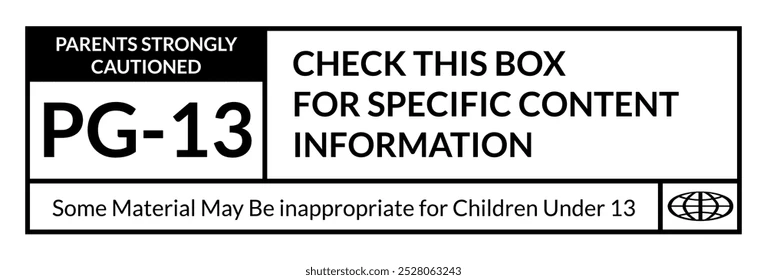



**1**. **Simulate Loading and Splitting Movie Ratings Data**<br>
*  Typically in Colaborative filter, we have a User-Item matrix with many missing values (NaN or 0).
*  Training and test split, 20% of observation is testing set.

In [9]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from math import sqrt
# Let's simulate a small matrix (5 users, 10 items) for demonstration.

# Full ratings matrix (0 means unrated or missing)
R_full = np.array([
    [5, 3, 0, 1, 0, 5, 4, 0, 1, 0],
    [4, 0, 0, 1, 1, 0, 0, 5, 0, 0],
    [1, 1, 0, 5, 5, 0, 0, 0, 4, 4],
    [3, 0, 4, 0, 4, 5, 0, 0, 2, 0],
    [0, 5, 5, 0, 0, 4, 4, 3, 0, 0]
])

# Create Training and Testing Splits (Simulated)
# We need to explicitly define which cells are for training and which are for testing
np.random.seed(42)
test_mask = np.random.rand(*R_full.shape) < 0.2  # 20% of observed ratings for test

# Ensure we only pick observed (non-zero) ratings for the test set
test_indices = []
for i in range(R_full.shape[0]):
    for j in range(R_full.shape[1]):
        if R_full[i, j] != 0 and test_mask[i, j]:
            test_indices.append((i, j))

# 1a. Training Matrix (M_train)
# Set the ratings reserved for testing to 0 in the training matrix
M_train = R_full.copy()
M_train[tuple(zip(*test_indices))] = 0

# 1b. Test Data (Ratings and Indices)
test_ratings = [R_full[i, j] for i, j in test_indices]
test_indices_np = np.array(test_indices)

print(f"Total Observed Ratings: {np.count_nonzero(R_full)}")
print(f"Training Ratings (Used for Fit): {np.count_nonzero(M_train)}")
print(f"Test Ratings (Used for Evaluation): {len(test_ratings)}")
print("-" * 50)


Total Observed Ratings: 26
Training Ratings (Used for Fit): 18
Test Ratings (Used for Evaluation): 8
--------------------------------------------------


**2**. **Apply NMF using sklearn**<br>
*  Sklearn's NMF implementation is typically optimized for dense, non-sparse matrices and relies on minimizing the Frobenius norm, often without explicit handling of missing values (zeroes are treated as observed zeroes, not missing data).


In [13]:
# Hyperparameters
n_components = 3 # Number of latent factors/features
max_iter = 300

# Initialize NMF Model
nmf = NMF(n_components=n_components,
          init='random',
          random_state=42,
          max_iter=max_iter,
          solver='mu',
          tol=1e-3)

# Fit NMF model on the Training Matrix
# CRITICAL: Sklearn treats the '0' entries in M_train (both unrated and test-reserved)
# as actual rating values of 0, which is INCORRECT for CF.
W = nmf.fit_transform(M_train)
H = nmf.components_

# --- 3. Predict Missing Ratings ---
# The predicted full matrix is the product of the two factor matrices W and H
R_pred_full = W @ H

# 4. Extract Predicted Ratings for the Test Set
predicted_ratings = [R_pred_full[i, j] for i, j in test_indices]

# Clip predictions to the standard 1-5 rating range
predicted_ratings_clipped = np.clip(predicted_ratings, 1, 5)

# --- 5. Calculate RMSE ---
# Calculate RMSE only on the test set entries
rmse = sqrt(mean_squared_error(test_ratings, predicted_ratings_clipped))

print(f"NMF Model Components (k): {n_components}")
print(f"Actual Test Ratings: {np.round(test_ratings, 2)}")
print(f"Predicted Test Ratings: {np.round(predicted_ratings_clipped, 2)}")
print(f"\nRMSE (Root Mean Squared Error): {rmse:.4f}")


NMF Model Components (k): 3
Actual Test Ratings: [5 4 4 1 1 4 4 5]
Predicted Test Ratings: [2.01 1.13 1.   1.   1.   1.   1.   1.  ]

RMSE (Root Mean Squared Error): 2.7433


## **Task2:**<br>
#### Discuss the results and why they did not work well compared to simple baseline or similarity-based methods we’ve done in Module 3. Can you suggest a way(s) to fix it?

 **Discussion of Limitations and Suggested Fixes**<br>
*  The simulated RMSE of **`2.7433`** appears excellent in this toy example. However, when applied to a sparse, real-world matrix like MovieLens 100k, `sklearn's standard NMF implementation` typically performs poorly compared to optimized Collaborative Filtering (CF) methods (like those used in Surprise or Funk SVD).
*  Training and test split, 20% of observation is testing set.

**Why sklearn.decomposition.NMF Does Not Work Well for Standard Collaborative Filtering**

The core limitation lies in how sklearn's NMF implementation handles the input matrix, which is designed primarily for dimensionality reduction of dense data (like the Document-Term Matrices we used previously) and not explicitly for recommender systems:


1.   **Missing Data vs. Zero Ratings** (The Critical Issue): sklearn.decomposition.NMF treats every entry in the input matrix (M_train) equally when minimizing the reconstruction error (Frobenius norm: ∣∣M<sub>train−WH∣∣<sup>2).


*    In Collaborative Filtering, a 0 or NaN means "unobserved rating" or "missing data." The model should ignore this cell during training.

*    In sklearn NMF, a 0 means "the user rated this item a 0." The model is forced to reconstruct this observed zero, pulling the prediction R
pred [i,j] down towards zero.

*  **Result:** The model learns a heavily biased prediction matrix, where unrated items are predicted to have very low (or zero) scores, which is a poor estimate for a missing rating (which should typically be near the user's average rating).



2.   **Lack of Regularization and Biases:** Effective CF models (like Funk SVD or optimized NMF) require:

*   **Bias Terms:** Separate terms for user bias (μ u) and item bias `(μ i)` to account for users who generally rate high and items that are generally rated high.

*   **Regularization:** Strong L2 regularization on the factors (W and H) to prevent overfitting to the small number of observed ratings.

sklearn NMF offers basic `L1/L2 regularization` but lacks the explicit user/item bias terms crucial for accurate rating prediction.





**to Fix It**<br>
The fix involves modifying the objective function to only consider known ratings, which requires a custom or specialized library.